In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from unet.unet_helpers import *
from unet.unet import UNet
from unet.utils import infere_model

In [3]:
labels = [0,1,2]
label_thresh = [20,220]
mask_label_info = [labels, label_thresh]
split_samples = None
# Original images
transformations = transforms.Compose([Rescale((128,128)), ToTensor()])
etching_dataset = MicroscopeImageDataset(img_dir=['./images/etching/set2/bottom/','./images/etching/set2/top/'], 
                                         mask_dir='./images/etching/set2/masks/',
                                         mask_label_info=mask_label_info, read_top=True,
                                         transf=transformations, split_samples=split_samples)

# Contrast, brightness adjusted
transformations = transforms.Compose([Rescale((128,128)), 
                                      BrightnessContrastAdjustment((-0.3,1.3), 'brightness'), 
                                      ToTensor()])
etching_dataset_bc = MicroscopeImageDataset(img_dir=['./images/etching/set2/bottom/','./images/etching/set2/top/'], 
                                         mask_dir='./images/etching/set2/masks/',
                                         mask_label_info=mask_label_info, read_top=True,
                                         transf=transformations, split_samples=split_samples)

# Rotated by 90 degrees
transformations = transforms.Compose([Rescale((128,128)), 
                                      Rotate(90), 
                                      ToTensor()])
etching_dataset_rotate = MicroscopeImageDataset(img_dir=['./images/etching/set2/bottom/','./images/etching/set2/top/'], 
                                         mask_dir='./images/etching/set2/masks/',
                                         mask_label_info=mask_label_info, read_top=True,
                                         transf=transformations, split_samples=split_samples)

combined_dset = ConcatDatasets(etching_dataset, etching_dataset_bc, etching_dataset_rotate)

In [ ]:
len(combined_dset)

In [ ]:
# Show the samples
fig = plt.figure(figsize=(20,13))

#for i in range(len(combined_dset)):
#    sample = combined_dset[i]
#    image, mask = sample['image'], sample['mask']
#    print(i, image.shape, mask.shape)

sample1 = combined_dset[2]
image1, mask1 = sample1['image'], sample1['mask']
    
sample2 = combined_dset[83]
image2, mask2 = sample2['image'], sample2['mask']

sample3 = combined_dset[164]
image3, mask3 = sample3['image'], sample3['mask']

ax1 = plt.subplot(1, 3, 1)
plt.imshow(mask1, cmap='gray', vmin=0, vmax=2)
print(mask1.shape)
ax1.axis('off')

ax2 = plt.subplot(1,3,2)
plt.imshow(image2[1,:,:], cmap='gray', vmin=0, vmax=1)
ax2.axis('off')

ax3 = plt.subplot(1,3,3)
plt.imshow(mask3, cmap='gray', vmin=0, vmax=2)
print(mask3.shape)
ax3.axis('off')

In [ ]:
for i in range(len(etching_dataset)):
    sample = etching_dataset[i]
    image, mask = sample['image'], sample['mask']

    ax = plt.subplot(10, 3, 3*i + 1)
    plt.imshow(image[0,:,:], cmap='gray', vmin=0, vmax=1)
    ax.set_title('Sample #{} trench bottom'.format(i))
    ax.axis('off')
    
    ax = plt.subplot(10, 3, 3*i + 2)
    plt.tight_layout()
    plt.imshow(image[1,:,:], cmap='gray', vmin=0, vmax=1)
    ax.set_title('Sample #{} top'.format(i))
    ax.axis('off')
    
    ax = plt.subplot(10, 3, 3*i + 3)
    plt.tight_layout()
    plt.imshow(mask, cmap='gray', vmin=0, vmax=2)
    ax.set_title('Sample #{} mask'.format(i))
    ax.axis('off')

    plt.tight_layout()
    if i == 9:
        plt.show()
        break

In [7]:
# Train parameter
epochs = 20
eta = 1e-3
lambda_l2 = 1e-3
gamma = 0.9
kernel_size = 3
depth = 4
n_filters = 3

# U-Net definition
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=2, n_classes=3, depth=depth, wf=n_filters, kernel_size=kernel_size, padding=True, up_mode='upconv', batch_norm=True).to(device)
optim = torch.optim.SGD(model.parameters(), lr=eta, momentum=gamma)
criterion = torch.nn.CrossEntropyLoss()
dataloader = DataLoader(combined_dset, batch_size=1,
                        shuffle=True, num_workers=4)

avg_epoch_loss, model = train_unet(model, device, optim, criterion, dataloader, 
                                   epochs=epochs, lambda_=1e-3, reg_type='l2', 
                                   save=False)


Epoch 0
Batch 10, Cross entropy loss: 1.35
Batch 20, Cross entropy loss: 1.24
Epoch 1
Batch 10, Cross entropy loss: 1.05
Batch 20, Cross entropy loss: 1.02
Epoch 2
Batch 10, Cross entropy loss: 0.95
Batch 20, Cross entropy loss: 0.89
Epoch 3
Batch 10, Cross entropy loss: 0.92
Batch 20, Cross entropy loss: 0.83
Epoch 4
Batch 10, Cross entropy loss: 0.77
Batch 20, Cross entropy loss: 0.83
Epoch 5
Batch 10, Cross entropy loss: 0.82
Batch 20, Cross entropy loss: 0.72
Epoch 6
Batch 10, Cross entropy loss: 0.67
Batch 20, Cross entropy loss: 0.66
Epoch 7
Batch 10, Cross entropy loss: 0.65
Batch 20, Cross entropy loss: 0.60
Epoch 8
Batch 10, Cross entropy loss: 0.66
Batch 20, Cross entropy loss: 0.59
Epoch 9
Batch 10, Cross entropy loss: 0.55
Batch 20, Cross entropy loss: 0.56
Epoch 10
Batch 10, Cross entropy loss: 0.55
Batch 20, Cross entropy loss: 0.52
Epoch 11
Batch 10, Cross entropy loss: 0.57
Batch 20, Cross entropy loss: 0.51
Epoch 12
Batch 10, Cross entropy loss: 0.54
Batch 20, Cross en

Text(0, 0.5, 'CrossEntropyLoss')

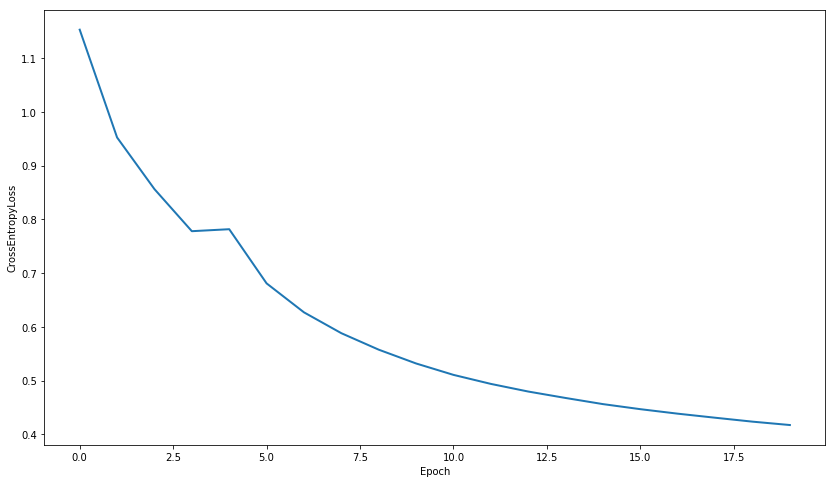

In [8]:
# Visualize
import numpy as np
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(np.arange(epochs), np.array(avg_epoch_loss), linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("CrossEntropyLoss")

C:\Users\silus\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\silus\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


torch.Size([2, 128, 128])


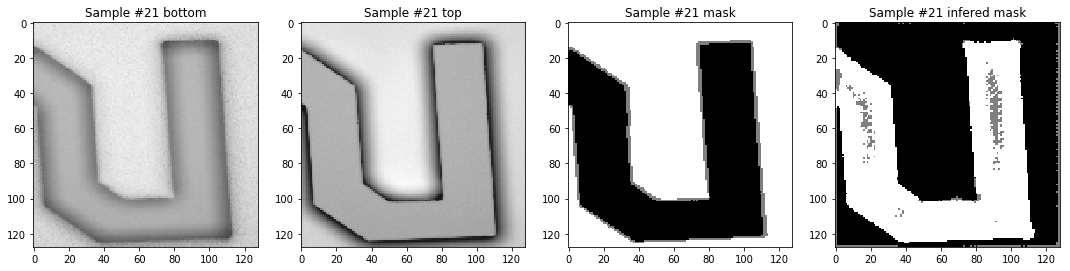

In [10]:
# Infere a sample
i = 21
sample = combined_dset[i]
image, mask = sample['image'], sample['mask']
infered_mask = infere_model(model, image)
image.squeeze_(0)
print(image.shape)
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(image[0,:,:], cmap='gray',vmin=0, vmax=1)
ax1.set_title('Sample #{} bottom'.format(i))

ax2 = fig.add_subplot(1,4,2)
ax2.imshow(image[1,:,:], cmap='gray',vmin=0, vmax=1)
ax2.set_title('Sample #{} top'.format(i))

ax3 = fig.add_subplot(1,4,3)
ax3.imshow(mask, cmap='gray', vmin=0,vmax=2)
ax3.set_title('Sample #{} mask'.format(i))

ax4 = fig.add_subplot(1,4,4)
ax4.imshow(infered_mask, cmap='gray', vmin=0,vmax=2)
ax4.set_title('Sample #{} infered mask'.format(i))
plt.tight_layout()

In [ ]:
infered_mask